# Walmart Retail Demand Forecasting

### Project Objective
To build a predictive model to forecast weekly sales for Walmart stores and departments. Accurate demand forecasting helps optimize inventory and reduce costs.

### Dataset Description
- **train.csv:** Historical sales data including Store, Dept, Date, Weekly_Sales
- **features.csv:** Additional features like temperature, CPI, markdowns, holidays
- **stores.csv:** Store information, including type and size
- **test.csv:** Test data for which predictions are needed

### Technologies & Libraries Used
- Python (pandas, numpy, scikit-learn, matplotlib)
- Jupyter Notebook
- Tableau (for visualization)

### Overview of Approach
- Data cleaning and merging datasets
- Feature engineering, including lag features and time variables
- Training a Random Forest regression model
- Model evaluation using MAE and RMSE
- Visualization of actual vs predicted sales


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

%matplotlib inline


## Data Loading and Inspection

In [2]:
train =  pd.read_csv(r'F:\Projects\Data Visualisation\Walmart\Raw Dataset\train.csv')
features = pd.read_csv(r'F:\Projects\Data Visualisation\Walmart\Raw Dataset\features.csv')
stores = pd.read_csv(r'F:\Projects\Data Visualisation\Walmart\Raw Dataset\stores.csv')
test = pd.read_csv(r'F:\Projects\Data Visualisation\Walmart\Raw Dataset\test.csv')


In [3]:
print("Train columns:"), train.columns
print("Features columns:"), features.columns 
print("Stores columnns:"), stores.columns
print("Test columns:"), test.columns


Train columns:
Features columns:
Stores columnns:
Test columns:


(None, Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object'))

In [4]:
print(train.head())
print(features.head())
print(stores.head())
print(test.head())


   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211

## Data Cleaning and Preparation

In [5]:
# Merge train data with features on Store and Date
train_full = train.merge(features, on=['Store', 'Date'], how='left')

# Merge with store info on Store
train_full = train_full.merge(stores, on='Store', how='left')
print(train_full.head())


   Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
0      1     1  2010-02-05      24924.50        False        42.31   
1      1     1  2010-02-12      46039.49         True        38.51   
2      1     1  2010-02-19      41595.55        False        39.93   
3      1     1  2010-02-26      19403.54        False        46.63   
4      1     1  2010-03-05      21827.90        False        46.50   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.548        NaN        NaN        NaN        NaN        NaN   
2       2.514        NaN        NaN        NaN        NaN        NaN   
3       2.561        NaN        NaN        NaN        NaN        NaN   
4       2.625        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  IsHoliday_y Type    Size  
0  211.096358         8.106        False    A  151315  
1  211.242170         8.106       

In [6]:
print(train_full.isnull().sum())


Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64


In [7]:
train_full.fillna(0, inplace=True)


## Feature Engineering

In [8]:
# Creating time-based features and lag variables to capture temporal dependencies.
train_full['Date'] = pd.to_datetime(train_full['Date'])


In [9]:
train_full['DayOfWeek'] = train_full['Date'].dt.dayofweek
train_full['Month'] = train_full['Date'].dt.month

train_full['Year'] = train_full['Date'].dt.year

In [10]:
print(train_full[['Date', 'DayOfWeek', 'Month', 'Year']].head())
print(train_full.dtypes)


        Date  DayOfWeek  Month  Year
0 2010-02-05          4      2  2010
1 2010-02-12          4      2  2010
2 2010-02-19          4      2  2010
3 2010-02-26          4      2  2010
4 2010-03-05          4      3  2010
Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday_x               bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday_y               bool
Type                    object
Size                     int64
DayOfWeek                int32
Month                    int32
Year                     int32
dtype: object


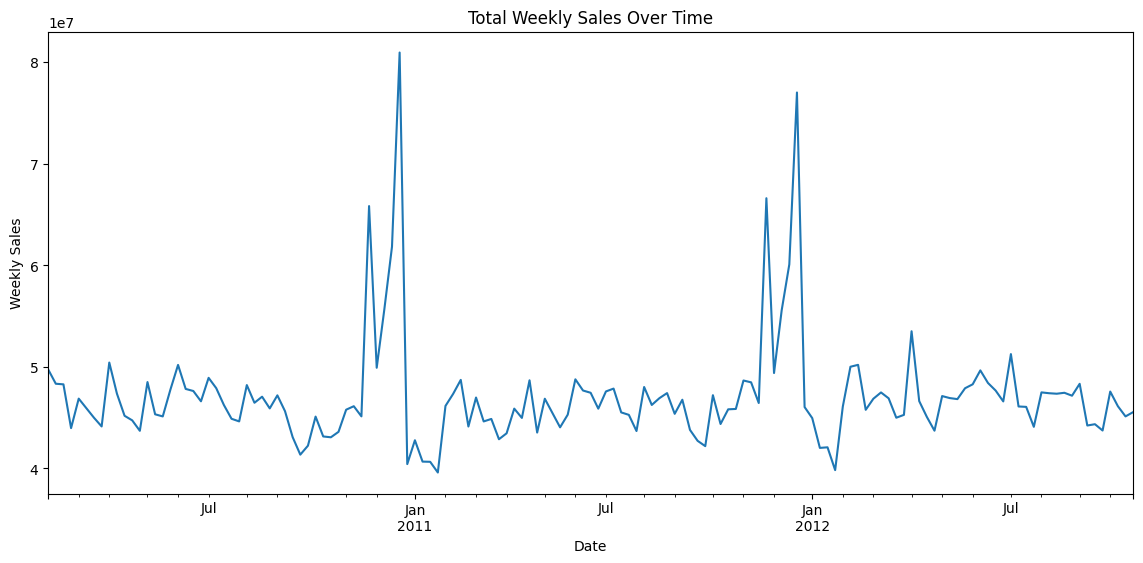

In [11]:
weekly_sales = train_full.groupby('Date')['Weekly_Sales'].sum()
weekly_sales.plot(figsize=(14,6), title='Total Weekly Sales Over Time')
plt.ylabel('Weekly Sales')
plt.show()


In [12]:
train_full['DayOfWeek'] = train_full['Date'].dt.dayofweek
train_full['Month'] = train_full['Date'].dt.month
train_full['Year'] = train_full['Date'].dt.year

train_full = train_full.sort_values(by=['Store', 'Dept', 'Date'])

# Lag feature: previous week's sales, per Store and Dept
train_full['Lag_1'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)

# Rolling mean: average of last 4 weeks' sales (excluding current week)
train_full['RollingMean_4'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.shift().rolling(window=4).mean())

# Fill missing lag and rolling mean values with 0 (for first weeks)
train_full['Lag_1'] = train_full['Lag_1'].fillna(0)
train_full['RollingMean_4'] = train_full['RollingMean_4'].fillna(0)


## Encoding Categorical Variables

In [13]:
# Encode Store and Dept using LabelEncoder
le_store = LabelEncoder()
le_dept = LabelEncoder()

train_full['Store_enc'] = le_store.fit_transform(train_full['Store'])
train_full['Dept_enc'] = le_dept.fit_transform(train_full['Dept'])


## Train-Test Split

In [14]:
# Set cutoff date at 80th percentile of dates for train-test split
cutoff_date = train_full['Date'].quantile(0.8)

# Create training and testing datasets based on cutoff
train_set = train_full[train_full['Date'] <= cutoff_date]
test_set = train_full[train_full['Date'] > cutoff_date]


In [15]:
print(train_set.columns)
print(test_set.columns)


Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size',
       'DayOfWeek', 'Month', 'Year', 'Lag_1', 'RollingMean_4', 'Store_enc',
       'Dept_enc'],
      dtype='object')
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size',
       'DayOfWeek', 'Month', 'Year', 'Lag_1', 'RollingMean_4', 'Store_enc',
       'Dept_enc'],
      dtype='object')


## Model Training

In [16]:
features = ['Store_enc', 'Dept_enc', 'DayOfWeek', 'Month', 'Year', 'Lag_1', 'RollingMean_4']
target = 'Weekly_Sales'

X_train = train_set[features]
y_train = train_set[target]
X_test = test_set[features]
y_test = test_set[target]


In [17]:
print(train_full.columns)
print(train_full[['Store', 'Dept']].head())


Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size',
       'DayOfWeek', 'Month', 'Year', 'Lag_1', 'RollingMean_4', 'Store_enc',
       'Dept_enc'],
      dtype='object')
   Store  Dept
0      1     1
1      1     1
2      1     1
3      1     1
4      1     1


In [18]:
le_store = LabelEncoder()
le_dept = LabelEncoder()

train_full['Store_enc'] = le_store.fit_transform(train_full['Store'])

train_full['Dept_enc'] = le_dept.fit_transform(train_full['Dept'])


In [19]:
cutoff_date = train_full['Date'].quantile(0.8)
train_set = train_full[train_full['Date'] <= cutoff_date]
test_set = train_full[train_full['Date'] > cutoff_date]


In [20]:
features = ['Store_enc', 'Dept_enc', 'DayOfWeek', 'Month', 'Year', 'Lag_1', 'RollingMean_4']


In [21]:
print(train_set.columns)


Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size',
       'DayOfWeek', 'Month', 'Year', 'Lag_1', 'RollingMean_4', 'Store_enc',
       'Dept_enc'],
      dtype='object')


In [22]:
X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]


In [23]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest Regressor with chosen hyperparameters
model = RandomForestRegressor(n_estimators=100, random_state=42)


In [24]:
# Train model
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
# Predict on test set
y_pred = model.predict(X_test)


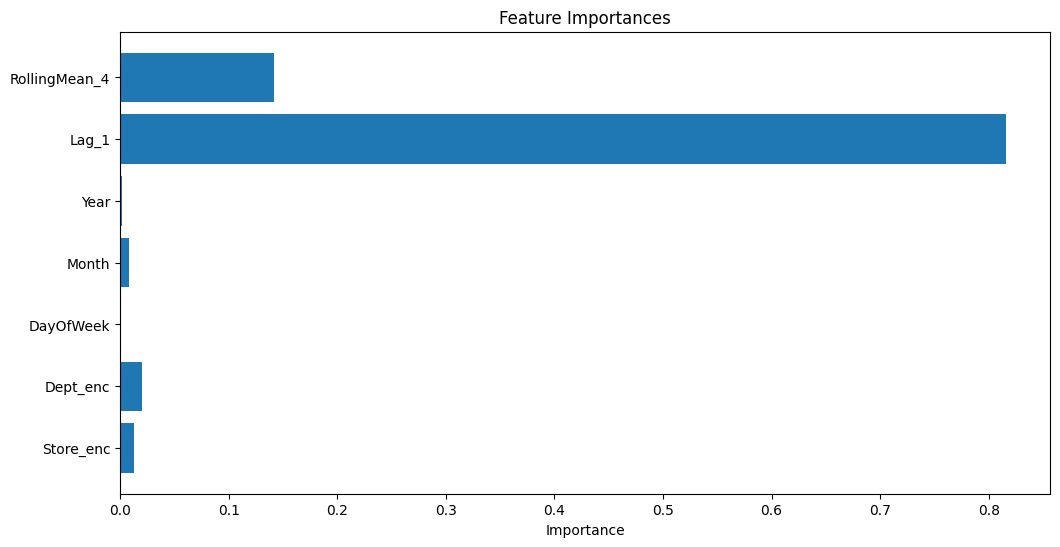

In [26]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = features

plt.figure(figsize=(12,6))
plt.barh(feature_names, importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.show()


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')


Mean Absolute Error: 1472.96
Root Mean Squared Error: 3135.43


In [28]:
print(test_set['Store'].unique())
print(test_set['Dept'].unique())


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 52 54
 55 56 58 59 60 67 71 72 74 79 80 81 82 83 85 87 90 91 92 93 94 95 96 97
 98 99 78 51 77 50 39 43 65]


## Predictions and Visualization

C:\Users\Abhi\AppData\Local\Temp\ipykernel_26764\2781001481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.loc[:, 'Predicted_Sales'] = y_pred


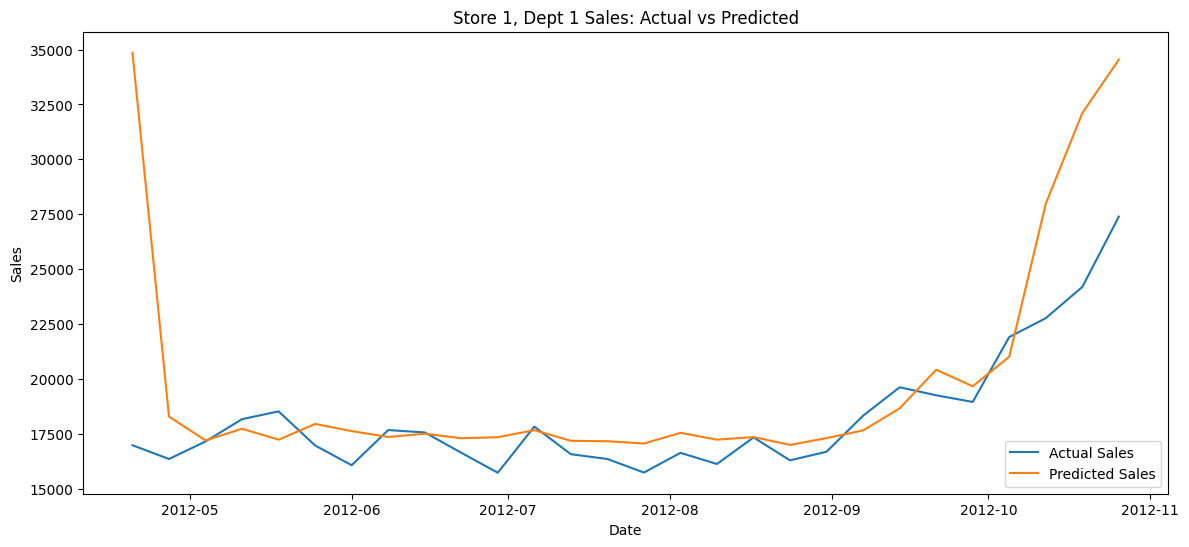

In [29]:
test_set.loc[:, 'Predicted_Sales'] = y_pred

sample_store = 1 
sample_dept = 1   

sample_data = test_set[(test_set['Store'] == sample_store) & (test_set['Dept'] == sample_dept)]

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'], label='Actual Sales')
plt.plot(sample_data['Date'], sample_data['Predicted_Sales'], label='Predicted Sales')
plt.title(f'Store {sample_store}, Dept {sample_dept} Sales: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


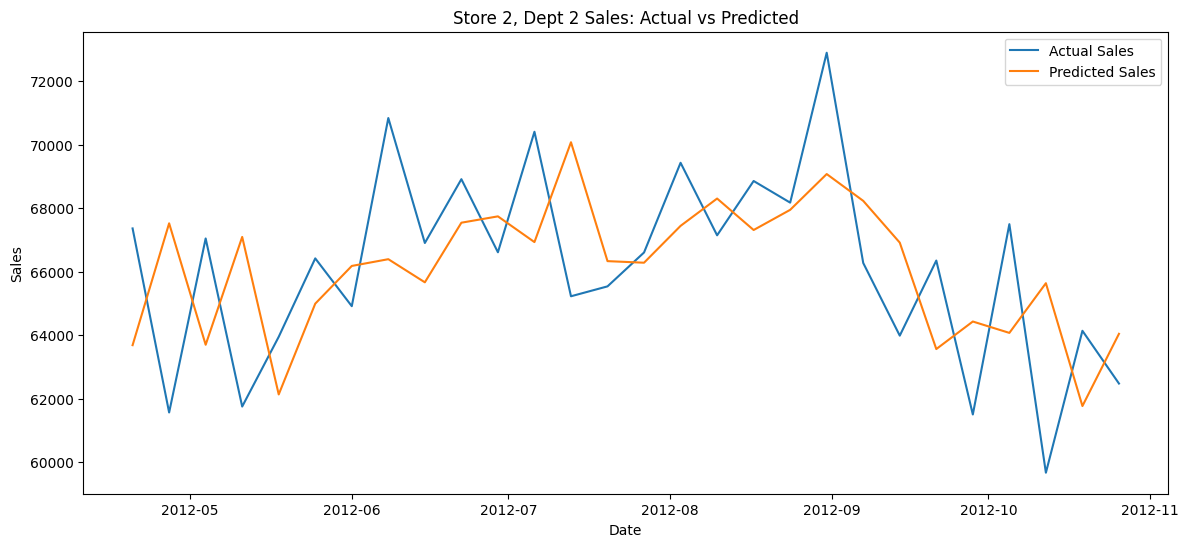

In [30]:
test_set.loc[:, 'Predicted_Sales'] = y_pred

sample_store = 2 
sample_dept = 2  

sample_data = test_set[(test_set['Store'] == sample_store) & (test_set['Dept'] == sample_dept)]

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'], label='Actual Sales')
plt.plot(sample_data['Date'], sample_data['Predicted_Sales'], label='Predicted Sales')
plt.title(f'Store {sample_store}, Dept {sample_dept} Sales: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [31]:
num_stores = train_full['Store'].nunique()
print(f'Total unique stores in dataset: {num_stores}')


Total unique stores in dataset: 45


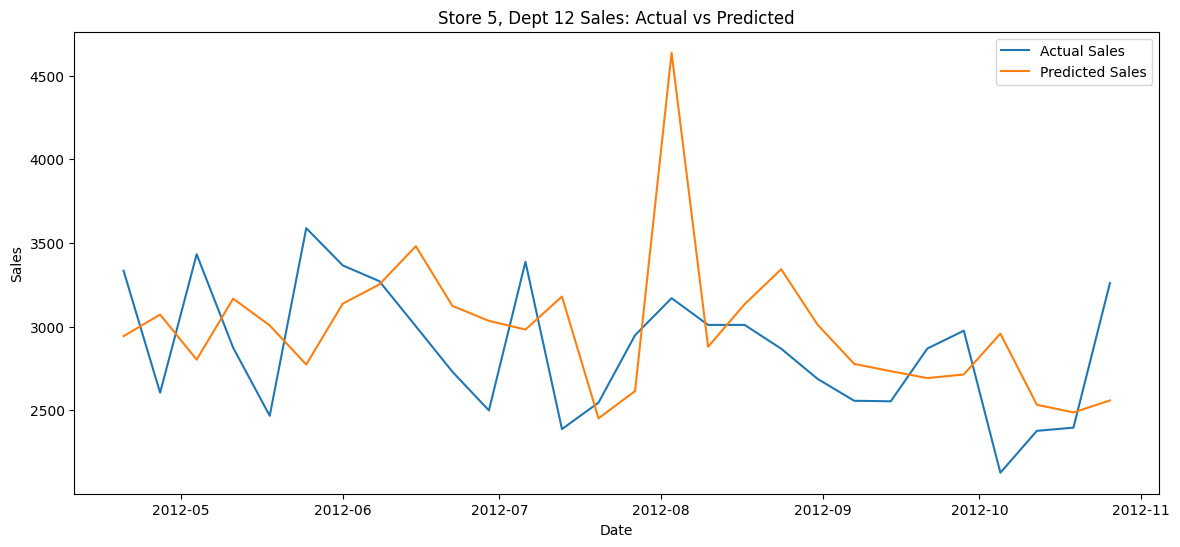

In [32]:
test_set.loc[:, 'Predicted_Sales'] = y_pred

sample_store = 5 
sample_dept = 12  

sample_data = test_set[(test_set['Store'] == sample_store) & (test_set['Dept'] == sample_dept)]

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'], label='Actual Sales')
plt.plot(sample_data['Date'], sample_data['Predicted_Sales'], label='Predicted Sales')
plt.title(f'Store {sample_store}, Dept {sample_dept} Sales: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


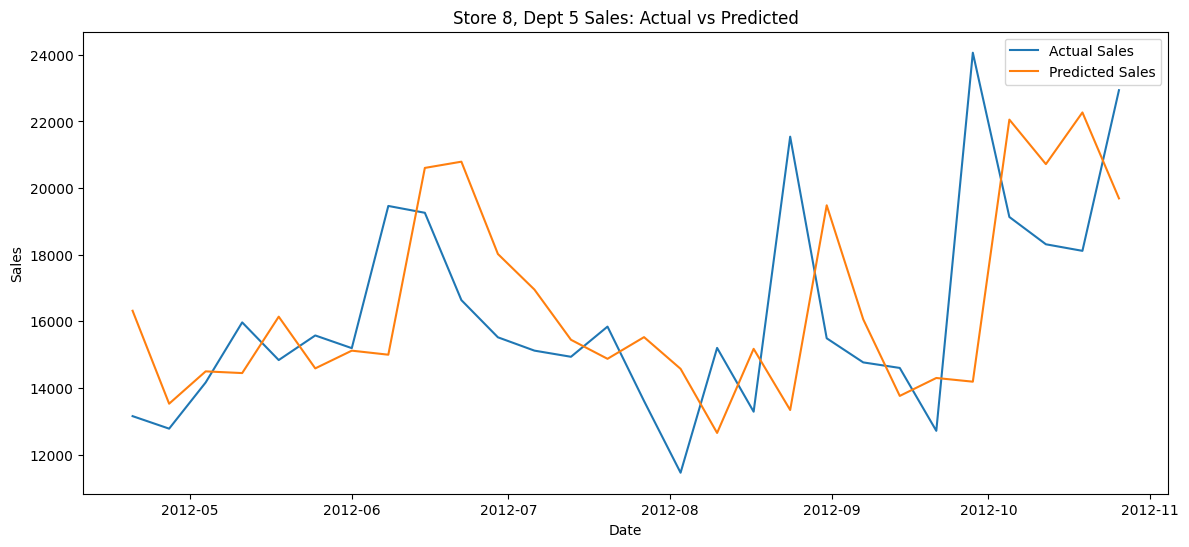

In [33]:
test_set.loc[:, 'Predicted_Sales'] = y_pred

sample_store = 8 
sample_dept = 5  

sample_data = test_set[(test_set['Store'] == sample_store) & (test_set['Dept'] == sample_dept)]

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'], label='Actual Sales')
plt.plot(sample_data['Date'], sample_data['Predicted_Sales'], label='Predicted Sales')
plt.title(f'Store {sample_store}, Dept {sample_dept} Sales: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


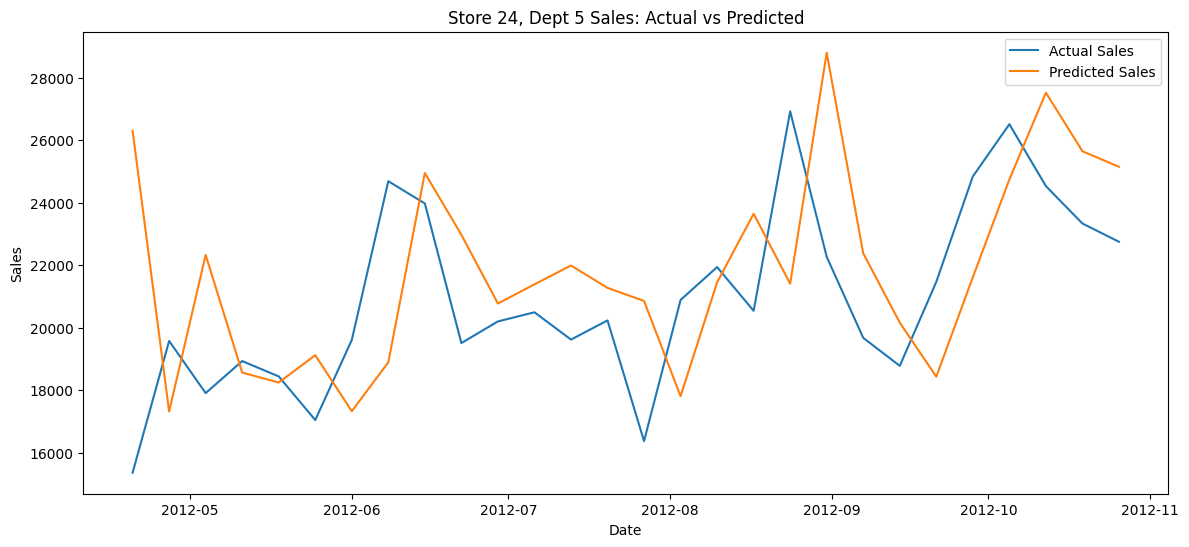

In [34]:
test_set.loc[:, 'Predicted_Sales'] = y_pred

sample_store = 24 
sample_dept = 5  

sample_data = test_set[(test_set['Store'] == sample_store) & (test_set['Dept'] == sample_dept)]

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'], label='Actual Sales')
plt.plot(sample_data['Date'], sample_data['Predicted_Sales'], label='Predicted Sales')
plt.title(f'Store {sample_store}, Dept {sample_dept} Sales: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [35]:
# Export to CSV for Tableau dashboard
test_set.to_csv("walmart_predictions.csv", index=False, encoding="utf-8")
print("Saved predictions to walmart_predictions.csv")


Saved predictions to walmart_predictions.csv
